<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/AL_with_CrisisMMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Project/multimodal_social_media

In [ ]:
pip install modal

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, metrics
from dataclasses import dataclass
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling

from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

from sklearn.neighbors import KNeighborsClassifier
import time
import random

In [4]:
@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float

def load_data(filename, nb_instance, all_instance):
  n = all_instance #number of records in file
  s = nb_instance #desired sample size
  skip = sorted(random.sample(range(1,n+1),n-s))

  #df = pd.read_csv(filename,sep="\t",nrows=nb_instance)
  df = pd.read_csv(filename,sep="\t",skiprows=skip)

  df.label_image = pd.Categorical(df.label_image)
  df['label_image_code'] = df.label_image.cat.codes

  df[['image','label_image','label_image_code']]

  df.describe()
  return df

def pre_process_image(data):
  img_arr = []
  for index,row in data.iterrows():
    read_img = cv2.imread(row['image'],0)
    img_resize = cv2.resize(read_img,(224,224))
    img_ravel = img_resize.ravel()
    img_arr.append(img_ravel)

  img_np = np.array(img_arr)

  return img_np

def random_forest_score(n_initial,n_queries,sampling_strategy):
  start_time = time.time()
  acc_all = []
 
  for i in n_initial:
    
    initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    
    learner = ActiveLearner(
            estimator=RandomForestClassifier(),
            query_strategy=sampling_strategy,
            X_training=X_initial,y_training=y_initial
            )
 
    for j in range(n_queries):
      res = [learner.score(X_test,y_test)]
      query_idx, query_inst = learner.query(X_pool)
      learner.teach(query_inst, y_pool[query_idx])
      X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

    acc = learner.score(X_test,y_test)
    acc_all.append(acc)


  final_time = time.time() - start_time

  predictions = learner.predict(X_test)
  res_classification = classification_report(y_test, predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time

def random_forest_score_repeat(n_initial,n_queries,sampling_strategy, repeats):
  
  start_time = time.time()
  acc_all = []
  experiments = []
  
  for k in tqdm(range(repeats)):
    print(k)
    for i in n_initial:
      np.random.seed(123)
      print(i)
      initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
     
      X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

      X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

      learner = ActiveLearner(
              estimator=RandomForestClassifier(),
              query_strategy=sampling_strategy,
              X_training=X_initial,y_training=y_initial
              )
      acc = learner.score(X_test,y_test)
      #acc_all.append(acc)

      predictions = learner.predict_proba(X_test)
      res_logloss = log_loss(y_test,predictions)

      experiments.append(Experiment(n_samples=i, repeat=k, accuracy=res_logloss))
      
      for j in range(n_queries):
        res = [learner.score(X_test,y_test)]
        query_idx, query_inst = learner.query(X_pool)
        learner.teach(query_inst, y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

      #acc = learner.score(X_test,y_test)
      #acc_all.append(acc)

      predictions = learner.predict_proba(X_test)
      res_logloss = log_loss(y_test,predictions)

      experiments.append(Experiment(n_samples=i+n_queries, repeat=k, accuracy=res_logloss))
      

  final_time = time.time() - start_time

  predictions = learner.predict(X_test)
  #predictions = learner.predict_proba(X_test)
  res_classification = classification_report(y_test, predictions)
  #res_classification = log_loss(y_test,predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time, experiments

In [36]:
# Random sampling

def random_selection_learning(n_instances, X_train, y_train):
    np.random.seed(123)
    clf = RandomForestClassifier()
   
    # X_selected, X_not_selected, y_selected, y_not_selected = \
    #     train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)

    initial_idx = np.random.choice(range(len(X_train)), size=n_instances, replace=False)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
  
    #clf.fit(X_selected, y_selected)
    #return clf, X_selected, X_not_selected, y_selected, y_not_selected

    clf.fit(X_initial,y_initial)

    return clf, X_initial, X_pool, y_initial, y_pool

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    
    return accuracy

def learning_curve(data_points, repeats, selection_policy):
    start_time = time.time()
    experiments = []
    for i in tqdm(range(repeats)):
        #np.random.seed(123)
        # First learn 
        n_samples = data_points[0]
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        #acc_random = evaluate(model, X_test, y_test)
        #experiments.append(acc_random)

        predictions = model.predict_proba(X_test)
        res_logloss = log_loss(y_test,predictions)

        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=res_logloss))
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
      
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
      
            model.fit(X_selected, y_selected)
            #acc_random = evaluate(model, X_test, y_test)
            #experiments.append(acc_random)

            predictions = model.predict_proba(X_test)
            res_logloss = log_loss(y_test,predictions)

            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=res_logloss))
    final_time = time.time() - start_time

    predictions = model.predict(X_test)
    res_classification = classification_report(y_test, predictions)
    
    print("--- %s seconds ---" % (final_time))

    return experiments, res_classification, final_time

In [6]:
# Load CrisisMMD data

start_time = time.time()

#train_instance = 9601
#test_instance = 1534

all_train_instance = 9601
all_test_instance = 1534

train_instance = 960
test_instance = 153

train_filename = "data/task_data/task_informative_text_img_agreed_lab_train.tsv"
test_filename = "data/task_data/task_informative_text_img_agreed_lab_test.tsv"

data_train = load_data(train_filename,train_instance, all_train_instance)
data_images_train = pre_process_image(data_train)

data_test = load_data(test_filename,test_instance, all_test_instance)
data_image_test = pre_process_image(data_test)

X_train = data_images_train.reshape(train_instance,-1)
y_train = data_train['label_image_code'].values

X_test = data_image_test.reshape(test_instance,-1)
y_test = data_test['label_image_code'].values

final_time = time.time() - start_time
print("--- %s seconds ---" % (final_time))

--- 872.8039484024048 seconds ---


In [ ]:
print("Train data distribution")

notinf_y_train = y_train[y_train == 1]
len_notinf = len(notinf_y_train)
print("Not Informative ",len_notinf)

inf_y_train = y_train[y_train == 0]
len_inf = len(inf_y_train)
print("Informative ",len_inf)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf,len_notinf]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Training Data Distribution')

plt.show()

In [ ]:
print("Test data distribution")

notinf_y_test = y_test[y_test == 1]
len_notinf_test = len(notinf_y_test)
print("Not Informative ",len_notinf_test)

inf_y_test = y_test[y_test == 0]
len_inf_test = len(inf_y_test)
print("Informative ",len_inf_test)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf_test,len_notinf_test]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Testing Data Distribution')

plt.show()

In [47]:
n_initial = range(30,700,20)
n_queries = 10
repeats = 3

In [48]:
result_rf_uncertainty, result_rf_acc_uncertainty, result_rf_time_uncertainty, experiment_uncertainty = random_forest_score_repeat(n_initial,n_queries,uncertainty_sampling,repeats)
print(experiment_uncertainty)


  0%|          | 0/3 [00:00<?, ?it/s]

0
30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330
350
370
390
410
430
450
470
490
510
530
550
570
590
610
630
650
670
690


 33%|███▎      | 1/3 [23:11<46:22, 1391.17s/it]

1
30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330
350
370
390
410
430
450
470
490
510
530
550
570
590
610
630
650
670
690


 67%|██████▋   | 2/3 [46:05<23:06, 1386.10s/it]

2
30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330
350
370
390
410
430
450
470
490
510
530
550
570
590
610
630
650
670
690


100%|██████████| 3/3 [1:09:05<00:00, 1381.82s/it]

--- 4145.4592361450195 seconds ---
[Experiment(n_samples=30, repeat=0, accuracy=0.6466636605979406), Experiment(n_samples=40, repeat=0, accuracy=0.6700947150627999), Experiment(n_samples=50, repeat=0, accuracy=0.6347091744636587), Experiment(n_samples=60, repeat=0, accuracy=0.63948782011978), Experiment(n_samples=70, repeat=0, accuracy=0.6192815778156936), Experiment(n_samples=80, repeat=0, accuracy=0.6302745000414771), Experiment(n_samples=90, repeat=0, accuracy=0.623861200658591), Experiment(n_samples=100, repeat=0, accuracy=0.6519644692212122), Experiment(n_samples=110, repeat=0, accuracy=0.6376076707427133), Experiment(n_samples=120, repeat=0, accuracy=0.6271092530801373), Experiment(n_samples=130, repeat=0, accuracy=0.6538143758606969), Experiment(n_samples=140, repeat=0, accuracy=0.626588141228139), Experiment(n_samples=150, repeat=0, accuracy=0.6391384810453016), Experiment(n_samples=160, repeat=0, accuracy=0.6337419049252713), Experiment(n_samples=170, repeat=0, accuracy=0.6467

In [25]:
result_rf_margin, result_rf_acc_margin, result_rf_time_margin, experiment_margin = random_forest_score_repeat(n_initial,n_queries,margin_sampling,repeats)
print(experiment_margin)

  0%|          | 0/3 [00:00<?, ?it/s]

0
30
50
70
90
110
130
150
170
190
210
230
250
270
290


 33%|███▎      | 1/3 [03:38<07:16, 218.38s/it]

1
30
50
70
90
110
130
150
170
190
210
230
250
270
290


 67%|██████▋   | 2/3 [07:13<03:37, 217.53s/it]

2
30
50
70
90
110
130
150
170
190
210
230
250
270
290


100%|██████████| 3/3 [10:54<00:00, 218.08s/it]

--- 654.2534215450287 seconds ---
[Experiment(n_samples=30, repeat=0, accuracy=0.6466636605979406), Experiment(n_samples=40, repeat=0, accuracy=0.6700947150627999), Experiment(n_samples=50, repeat=0, accuracy=0.6347091744636587), Experiment(n_samples=60, repeat=0, accuracy=0.63948782011978), Experiment(n_samples=70, repeat=0, accuracy=0.6192815778156936), Experiment(n_samples=80, repeat=0, accuracy=0.6302745000414771), Experiment(n_samples=90, repeat=0, accuracy=0.623861200658591), Experiment(n_samples=100, repeat=0, accuracy=0.6519644692212122), Experiment(n_samples=110, repeat=0, accuracy=0.6376076707427133), Experiment(n_samples=120, repeat=0, accuracy=0.6271092530801373), Experiment(n_samples=130, repeat=0, accuracy=0.6538143758606969), Experiment(n_samples=140, repeat=0, accuracy=0.626588141228139), Experiment(n_samples=150, repeat=0, accuracy=0.6391384810453016), Experiment(n_samples=160, repeat=0, accuracy=0.6337419049252713), Experiment(n_samples=170, repeat=0, accuracy=0.64676

In [26]:
result_rf_entropy, result_rf_acc_entropy, result_rf_time_entropy, experiment_entropy = random_forest_score_repeat(n_initial,n_queries,entropy_sampling,repeats)
print(experiment_entropy)

  0%|          | 0/3 [00:00<?, ?it/s]

0
30
50
70
90
110
130
150
170
190
210
230
250
270
290


 33%|███▎      | 1/3 [03:33<07:06, 213.21s/it]

1
30
50
70
90
110
130
150
170
190
210
230
250
270
290


 67%|██████▋   | 2/3 [07:07<03:33, 213.43s/it]

2
30
50
70
90
110
130
150
170
190
210
230
250
270
290


100%|██████████| 3/3 [10:35<00:00, 211.96s/it]

--- 635.8716697692871 seconds ---
[Experiment(n_samples=30, repeat=0, accuracy=0.6466636605979406), Experiment(n_samples=40, repeat=0, accuracy=0.6700947150627999), Experiment(n_samples=50, repeat=0, accuracy=0.6347091744636587), Experiment(n_samples=60, repeat=0, accuracy=0.63948782011978), Experiment(n_samples=70, repeat=0, accuracy=0.6192815778156936), Experiment(n_samples=80, repeat=0, accuracy=0.6302745000414771), Experiment(n_samples=90, repeat=0, accuracy=0.623861200658591), Experiment(n_samples=100, repeat=0, accuracy=0.6519644692212122), Experiment(n_samples=110, repeat=0, accuracy=0.6376076707427133), Experiment(n_samples=120, repeat=0, accuracy=0.6271092530801373), Experiment(n_samples=130, repeat=0, accuracy=0.6538143758606969), Experiment(n_samples=140, repeat=0, accuracy=0.626588141228139), Experiment(n_samples=150, repeat=0, accuracy=0.6391384810453016), Experiment(n_samples=160, repeat=0, accuracy=0.6337419049252713), Experiment(n_samples=170, repeat=0, accuracy=0.64676

In [49]:
n_initial = range(30,710,10)
experiment_random, res_random, time_random = learning_curve(n_initial,3, random_sampling_policy)

100%|██████████| 3/3 [12:45<00:00, 255.11s/it]

--- 765.3207383155823 seconds ---


In [38]:
print(experiment_uncertainty)
#print(experiment_margin)
#print(experiment_entropy)
print(experiment_random)

[Experiment(n_samples=30, repeat=0, accuracy=0.6466636605979406), Experiment(n_samples=40, repeat=0, accuracy=0.6700947150627999), Experiment(n_samples=50, repeat=0, accuracy=0.6347091744636587), Experiment(n_samples=60, repeat=0, accuracy=0.63948782011978), Experiment(n_samples=70, repeat=0, accuracy=0.6192815778156936), Experiment(n_samples=80, repeat=0, accuracy=0.6302745000414771), Experiment(n_samples=90, repeat=0, accuracy=0.623861200658591), Experiment(n_samples=100, repeat=0, accuracy=0.6519644692212122), Experiment(n_samples=110, repeat=0, accuracy=0.6376076707427133), Experiment(n_samples=120, repeat=0, accuracy=0.6271092530801373), Experiment(n_samples=130, repeat=0, accuracy=0.6538143758606969), Experiment(n_samples=140, repeat=0, accuracy=0.626588141228139), Experiment(n_samples=150, repeat=0, accuracy=0.6391384810453016), Experiment(n_samples=160, repeat=0, accuracy=0.6337419049252713), Experiment(n_samples=170, repeat=0, accuracy=0.6467609610466944), Experiment(n_samples

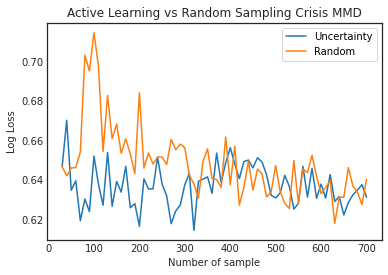

In [50]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Active Learning vs Random Sampling Crisis MMD')
        plt.plot(training_sizes, p50, label=name )

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='upper right')
    plt.xlabel("Number of sample")
    plt.ylabel("Log Loss")
    plt.grid()
    #plt.show()

df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiment_uncertainty])
#df_ms = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
#df_es = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
plot_learning_curve(df_us, "Uncertainty")
#plot_learning_curve(df_ms, "Margin")
#plot_learning_curve(df_es, "Entropy")
plot_learning_curve(df_rs, "Random")

In [ ]:
print(result_rf_uncertainty)
print(result_rf_margin)
print(result_rf_entropy)

print(result_rf_time_uncertainty)
print(result_rf_time_margin)
print(result_rf_time_entropy)

In [ ]:
print(res_random)
print(time_random)

**#Draft#**

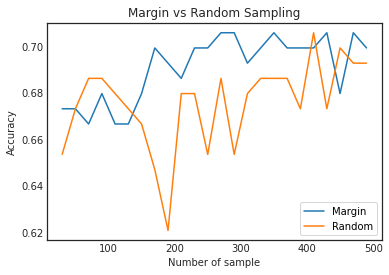

In [ ]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Margin vs Random Sampling')
        plt.plot(training_sizes, p50, label=name)

        # show standard deviation
        #plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number of sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

df_ma = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
plot_learning_curve(df_ma, "Margin")
plot_learning_curve(df_rs, "Random")

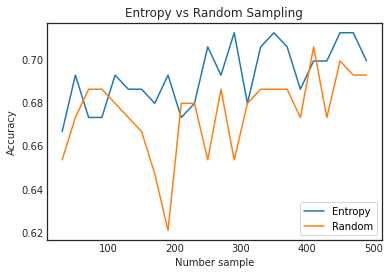

In [ ]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Entropy vs Random Sampling')
        plt.plot(training_sizes, p50, label=name)

        # show standard deviation
        #plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

df_en = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])

plot_learning_curve(df_en, "Entropy")
plot_learning_curve(df_rs, "Random")

In [ ]:
random_size = 1000
index = np.random.choice(range(len(X_train)),size=random_size,replace=False)

X_train_rf = X_train[index]
y_train_rf = y_train[index]
clf = RandomForestClassifier()
clf.fit(X_train_rf,y_train_rf)

res = clf.predict(X_test)
res_classification = classification_report(y_test, res)
print(res_classification)

In [ ]:
print(result_rf_acc_uncertainty)
print(result_rf_acc_margin)
print(result_rf_acc_entropy)

[0.7046936114732725, 0.7053455019556715, 0.6929595827900913, 0.7079530638852672, 0.6988265971316818, 0.7059973924380704, 0.6838331160365059, 0.7053455019556715, 0.7033898305084746, 0.7157757496740548]
[0.6460234680573663, 0.6694915254237288, 0.6701434159061278, 0.7079530638852672, 0.7066492829204694, 0.6936114732724902, 0.7066492829204694, 0.71251629726206, 0.7027379400260756, 0.7007822685788787]
[0.6590612777053455, 0.6831812255541069, 0.682529335071708, 0.6949152542372882, 0.6916558018252934, 0.6949152542372882, 0.711864406779661, 0.7073011734028684, 0.7046936114732725, 0.7020860495436767]


Uncertainty avg:  0.7024119947848761
Margin avg:  0.6916558018252934
Entropy avg:  0.6932203389830509
Random avg:  0.6942633637548892


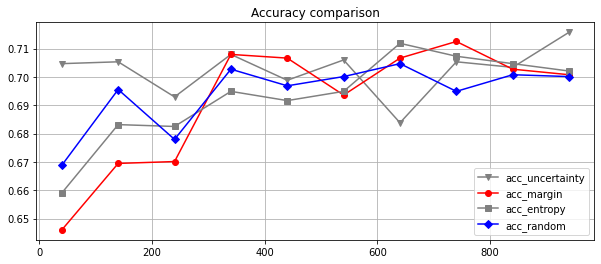

In [ ]:
print("Uncertainty avg: ",np.mean(result_rf_acc_uncertainty))
print("Margin avg: ",np.mean(result_rf_acc_margin))
print("Entropy avg: ",np.mean(result_rf_acc_entropy))
print("Random avg: ",np.mean(acc_random))
df = pd.DataFrame({'x_values':n_initial,'acc_uncertainty':np.array(result_rf_acc_uncertainty),'acc_margin':np.array(result_rf_acc_margin),'acc_entropy':np.array(result_rf_acc_entropy),'acc_random':np.array(acc_random)})

width_height_1 = (10, 4)
plt.figure(figsize=width_height_1)

plt.plot('x_values','acc_uncertainty',data=df,color='gray',marker='v')
plt.plot('x_values','acc_margin',data=df,color='red',marker='o')
plt.plot('x_values','acc_entropy',data=df,color='gray',marker='s')
plt.plot('x_values','acc_random',data=df,color='blue',marker='D')
plt.title('Accuracy comparison')
plt.legend()
plt.grid()
plt.show()